# ImageNet Training with ResNet-50

This notebook provides a complete pipeline for training ResNet-50 on ImageNet-1k dataset with options for:
- Training on small subset for quick experiments
- Finding optimal learning rate using LR Finder
- Full dataset training
- Using pretrained weights
- Replacing MaxPool with strided convolution

## 1. Setup Environment

In [2]:
# Check if running on Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running on Google Colab")
    from google.colab import drive
    drive.mount('/content/drive')
else:
    print("Running locally")

Running locally


In [ ]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install matplotlib tqdm scipy

In [3]:
# Clone or setup the repository
import os

if IN_COLAB:
    # Option 1: Clone from GitHub (if you have uploaded the code)
    # !git clone https://github.com/yourusername/S9_Assignment.git
    # os.chdir('S9_Assignment')
    
    # Option 2: Copy from Google Drive (if you have uploaded the code)
    # !cp -r /content/drive/MyDrive/S9_Assignment .
    # os.chdir('S9_Assignment')
    
    # Option 3: Upload the files directly
    print("Please upload the S9_Assignment folder to Colab or Google Drive")
    
# Add the parent directory to path
sys.path.append('..')

## 2. Import Required Modules

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR, CosineAnnealingLR
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import json

# Import custom modules
from models.resnet50_imagenet import resnet50
from dataset.imagenet_loader import create_imagenet_loaders
from utils.lr_finder import LRFinder
from utils.train_test import train_epoch, test_epoch

# Check CUDA availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

Using device: cuda
GPU: NVIDIA TITAN RTX
Number of GPUs: 1


In [6]:
!pwd

/home/xpz1/tsai_work/ERAV4/S9_Assignment/notebooks


## 3. Configuration

In [22]:
# Training configuration
config = {
    # Dataset
    'dataset_type': 'full',  # Options: 'small', 'medium', 'full', 'tiny_imagenet'
    'data_dir': '/home/xpz1/Downloads/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/',  # Update this path
    'batch_size': 128,  # Reduce if GPU memory is limited
    'num_workers': 4,
    
    # Model
    'pretrained': False,  # Use pretrained weights
    'replace_maxpool_with_conv': True,  # Replace MaxPool with Conv (default: True)
    
    # Training
    'epochs': 110,  # Increase for full training
    'learning_rate': 0.1,
    'momentum': 0.9,
    'weight_decay': 1e-4,
    'scheduler': 'onecycle',  # Options: 'onecycle', 'cosine', 'step', None
    
    # LR Finder
    'find_lr': True,  # Run LR finder before training
    'lr_finder_iterations': 100,
    
    # Paths
    'checkpoint_dir': './checkpoints',
    'log_dir': './logs',
    'plot_dir': './plots',
}

# Dataset size configurations
dataset_configs = {
    'small': {'subset_percent': 0.01, 'tiny_imagenet': False},  # 1% of ImageNet
    'medium': {'subset_percent': 0.1, 'tiny_imagenet': False},  # 10% of ImageNet
    'full': {'subset_percent': None, 'tiny_imagenet': False},   # Full ImageNet
    'tiny_imagenet': {'subset_percent': None, 'tiny_imagenet': True}  # Tiny ImageNet
}

# Update config based on dataset type
dataset_config = dataset_configs[config['dataset_type']]
config.update(dataset_config)

print("Configuration:")
for key, value in config.items():
    print(f"{key}: {value}")

Configuration:
dataset_type: full
data_dir: /home/xpz1/Downloads/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/
batch_size: 128
num_workers: 4
pretrained: False
replace_maxpool_with_conv: True
epochs: 110
learning_rate: 0.1
momentum: 0.9
weight_decay: 0.0001
scheduler: onecycle
find_lr: True
lr_finder_iterations: 100
checkpoint_dir: ./checkpoints
log_dir: ./logs
plot_dir: ./plots
subset_percent: None
tiny_imagenet: False


## 4. Download ImageNet Data (Instructions)

### Option 1: Tiny ImageNet (Recommended for testing)
Tiny ImageNet is a subset with 200 classes and smaller images (64x64).

In [ ]:
# Download Tiny ImageNet (only if using tiny_imagenet)
if config.get('tiny_imagenet', False):
    !wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
    !unzip -q tiny-imagenet-200.zip
    !mv tiny-imagenet-200 /content/tiny-imagenet
    config['data_dir'] = '/content/tiny-imagenet'

### Option 2: Full ImageNet-1k

For full ImageNet-1k dataset:

1. **Register and download from official source**: https://image-net.org/download.php
2. **Required files**:
   - Training images: `ILSVRC2012_img_train.tar` (~138GB)
   - Validation images: `ILSVRC2012_img_val.tar` (~6.3GB)
   - Development kit: `ILSVRC2012_devkit_t12.tar.gz`

3. **Extract the data**:

In [ ]:
# Commands to extract ImageNet (run in terminal or adapt for Colab)
# Note: This requires significant storage space (~150GB)

# # Create directories
# !mkdir -p /content/imagenet/train /content/imagenet/val

# # Extract training data
# !tar -xf ILSVRC2012_img_train.tar -C /content/imagenet/train/
# !cd /content/imagenet/train && for f in *.tar; do mkdir -p "${f%.tar}" && tar -xf "$f" -C "${f%.tar}" && rm "$f"; done

# # Extract validation data
# !tar -xf ILSVRC2012_img_val.tar -C /content/imagenet/val/
# # Use the validation ground truth to organize val images into folders
# # You'll need the ILSVRC2012_validation_ground_truth.txt file

### Option 3: Use a subset for quick experiments

If you have limited resources, you can:
1. Use Tiny ImageNet (recommended)
2. Use a small subset of ImageNet by setting `subset_percent` in config
3. Create your own small dataset with a few classes

## 5. Create Data Loaders

In [9]:
# Create data loaders
train_loader, val_loader, dataset_stats = create_imagenet_loaders(
    data_dir=config['data_dir'],
    batch_size=config['batch_size'],
    num_workers=config['num_workers'],
    subset_percent=config.get('subset_percent', None),
    tiny_imagenet=config.get('full', False),
    augment_train=True
)

print("\nDataset Statistics:")
for key, value in dataset_stats.items():
    print(f"{key}: {value}")


Dataset Statistics:
num_classes: 1000
num_train_samples: 1281167
num_val_samples: 50000
num_train_batches: 10009
num_val_batches: 391
batch_size: 128
image_size: (3, 224, 224)
mean: [0.485, 0.456, 0.406]
std: [0.229, 0.224, 0.225]


## 6. Create Model

In [ ]:
# Create model
model = resnet50(
    num_classes=dataset_stats['num_classes'],
    pretrained=config['pretrained'],
    replace_maxpool_with_conv=config['replace_maxpool_with_conv']
)

# Move to GPU if available
model = model.to(device)

# Multi-GPU training
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 25,594,024
Trainable parameters: 25,594,024


## 7. Learning Rate Finder

Running LR Finder...


LR Finder:  20%|██        | 20/100 [00:10<00:43,  1.82it/s, lr=6.58e-06, loss=4.5647]


Stopping early, loss diverged at lr=6.58e-06
LR range test complete. Best loss: 0.3660


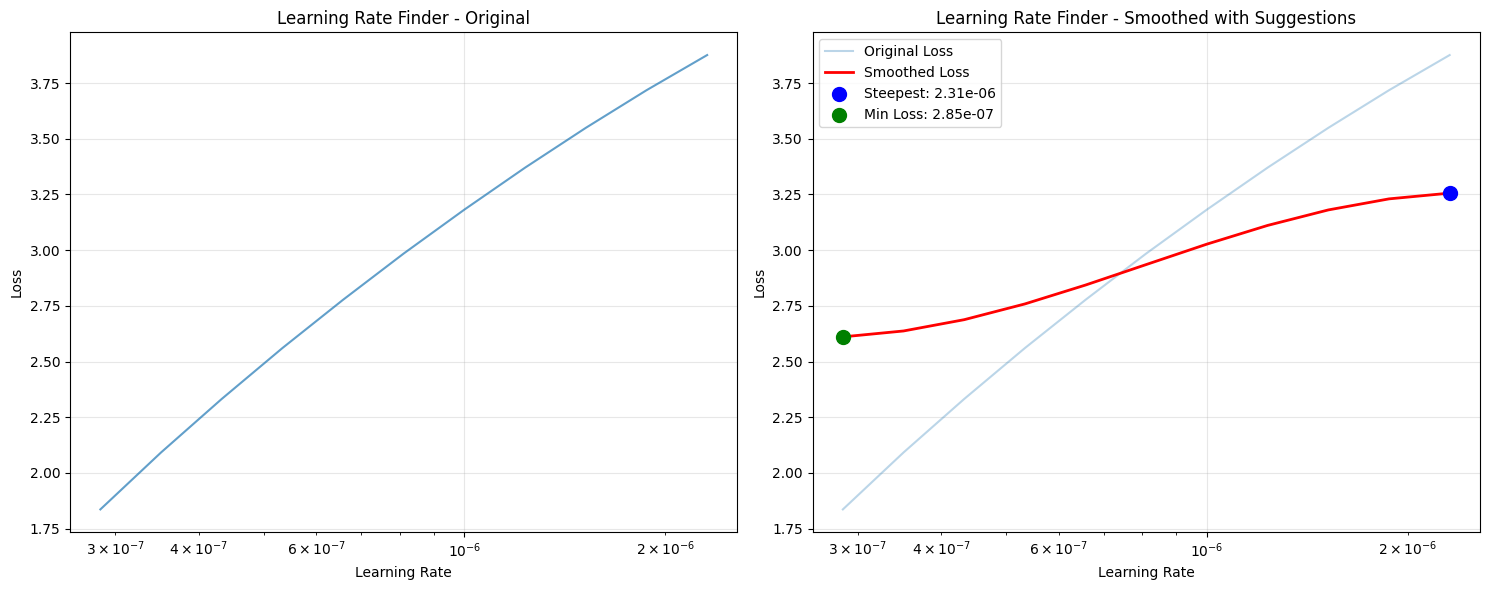


Suggested LR: 2.31e-06
Min Loss LR: 2.85e-07
Model and optimizer reset to initial state


In [20]:
if config['find_lr']:
    print("Running LR Finder...")
    
    # Create criterion and temporary optimizer
    criterion = nn.CrossEntropyLoss()
    temp_optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)
    
    # Create LR finder
    lr_finder = LRFinder(model, temp_optimizer, criterion, device)
    
    # Run range test
    lr_finder.range_test(
        train_loader,
        start_lr=1e-7,
        end_lr=100,
        num_iter=config['lr_finder_iterations'],
        step_mode='exp'
    )
    
    # Plot and find optimal LR
    suggested_lr, min_loss_lr = lr_finder.plot_with_suggestion()
    
    print(f"\nSuggested LR: {suggested_lr:.2e}")
    print(f"Min Loss LR: {min_loss_lr:.2e}")
    
    # Update config with suggested LR
    config['learning_rate'] = suggested_lr
    config['max_lr'] = suggested_lr
    
    # Reset model
    lr_finder.reset()

## 8. Setup Training

In [23]:
# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.SGD(
    model.parameters(),
    lr=config['learning_rate'],
    momentum=config['momentum'],
    weight_decay=config['weight_decay']
)

# Learning rate scheduler
scheduler = None
if config['scheduler'] == 'onecycle':
    scheduler = OneCycleLR(
        optimizer,
        max_lr=config.get('max_lr', config['learning_rate']),
        epochs=config['epochs'],
        steps_per_epoch=len(train_loader),
        pct_start=0.3,
        anneal_strategy='cos',
        div_factor=25.0,
        final_div_factor=10000.0
    )
elif config['scheduler'] == 'cosine':
    scheduler = CosineAnnealingLR(
        optimizer,
        T_max=config['epochs'],
        eta_min=1e-6
    )

print(f"Optimizer: {optimizer.__class__.__name__}")
print(f"Scheduler: {scheduler.__class__.__name__ if scheduler else 'None'}")
print(f"Initial LR: {optimizer.param_groups[0]['lr']:.2e}")

Optimizer: SGD
Scheduler: OneCycleLR
Initial LR: 4.00e-03


## 9. Training Loop

In [24]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'val_acc_top5': [],
    'lr': []
}

# Best model tracking
best_val_acc = 0
best_epoch = 0

# Create directories
Path(config['checkpoint_dir']).mkdir(parents=True, exist_ok=True)
Path(config['log_dir']).mkdir(parents=True, exist_ok=True)
Path(config['plot_dir']).mkdir(parents=True, exist_ok=True)

In [25]:
config['epochs']

110

In [ ]:
# Training loop
print("\nStarting Training...")
print("=" * 50)

for epoch in range(config['epochs']):
    # Training phase
    train_loss, train_acc = train_epoch(
        model, device, train_loader, optimizer, criterion,
        scheduler if config['scheduler'] == 'onecycle' else None,
        epoch, accumulation_steps=1, clip_grad_norm=None, verbose=True
    )
    
    # Validation phase
    val_loss, val_acc, val_acc_top5, _ = test_epoch(
        model, device, val_loader, criterion,
        epoch, verbose=True, calc_top5=True
    )
    
    # Update scheduler (for non-OneCycle)
    if scheduler and config['scheduler'] != 'onecycle':
        scheduler.step()
    
    # Get current LR
    current_lr = optimizer.param_groups[0]['lr']
    
    # Update history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_acc_top5'].append(val_acc_top5)
    history['lr'].append(current_lr)
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_acc': best_val_acc,
            'config': config
        }, f"{config['checkpoint_dir']}/best_model.pth")
    
    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{config['epochs']} Summary:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print(f"  Val Top-5 Acc: {val_acc_top5:.2f}%")
    print(f"  Learning Rate: {current_lr:.2e}")
    print(f"  Best Val Acc: {best_val_acc:.2f}% (Epoch {best_epoch+1})")
    print("=" * 50)

print("\nTraining Completed!")
print(f"Best Validation Accuracy: {best_val_acc:.2f}% at Epoch {best_epoch+1}")


Starting Training...


Epoch 0 [Test]: 100%|██████████| 391/391 [01:20<00:00,  4.86it/s, loss=6.0201, acc=6.83%, top5=20.39%]



Epoch 1/110 Summary:
  Train Loss: 6.2699, Train Acc: 1.74%
  Val Loss: 5.2393, Val Acc: 6.83%
  Val Top-5 Acc: 20.39%
  Learning Rate: 4.22e-03
  Best Val Acc: 6.83% (Epoch 1)


Epoch 1 [Test]: 100%|██████████| 391/391 [01:12<00:00,  5.37it/s, loss=5.4281, acc=19.69%, top5=42.65%]



Epoch 2/110 Summary:
  Train Loss: 4.9403, Train Acc: 9.88%
  Val Loss: 4.0803, Val Acc: 19.69%
  Val Top-5 Acc: 42.65%
  Learning Rate: 4.87e-03
  Best Val Acc: 19.69% (Epoch 2)


Epoch 2 [Test]: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s, loss=5.0301, acc=30.39%, top5=56.54%]



Epoch 3/110 Summary:
  Train Loss: 4.1088, Train Acc: 19.41%
  Val Loss: 3.2335, Val Acc: 30.39%
  Val Top-5 Acc: 56.54%
  Learning Rate: 5.94e-03
  Best Val Acc: 30.39% (Epoch 3)


Epoch 3 [Test]: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=4.5956, acc=36.46%, top5=63.37%]



Epoch 4/110 Summary:
  Train Loss: 3.6151, Train Acc: 26.43%
  Val Loss: 2.8772, Val Acc: 36.46%
  Val Top-5 Acc: 63.37%
  Learning Rate: 7.44e-03
  Best Val Acc: 36.46% (Epoch 4)


Epoch 4 [Test]: 100%|██████████| 391/391 [01:15<00:00,  5.18it/s, loss=4.4257, acc=40.71%, top5=67.82%]



Epoch 5/110 Summary:
  Train Loss: 3.3067, Train Acc: 31.28%
  Val Loss: 2.6370, Val Acc: 40.71%
  Val Top-5 Acc: 67.82%
  Learning Rate: 9.34e-03
  Best Val Acc: 40.71% (Epoch 5)


Epoch 5 [Test]: 100%|██████████| 391/391 [01:14<00:00,  5.26it/s, loss=4.1277, acc=45.43%, top5=72.02%]



Epoch 6/110 Summary:
  Train Loss: 3.0978, Train Acc: 34.73%
  Val Loss: 2.3831, Val Acc: 45.43%
  Val Top-5 Acc: 72.02%
  Learning Rate: 1.16e-02
  Best Val Acc: 45.43% (Epoch 6)


Epoch 6 [Test]: 100%|██████████| 391/391 [01:09<00:00,  5.59it/s, loss=4.2812, acc=47.18%, top5=74.10%]



Epoch 7/110 Summary:
  Train Loss: 2.9523, Train Acc: 37.18%
  Val Loss: 2.2862, Val Acc: 47.18%
  Val Top-5 Acc: 74.10%
  Learning Rate: 1.43e-02
  Best Val Acc: 47.18% (Epoch 7)


Epoch 7 [Test]: 100%|██████████| 391/391 [01:13<00:00,  5.29it/s, loss=3.5205, acc=48.26%, top5=74.70%]



Epoch 8/110 Summary:
  Train Loss: 2.8558, Train Acc: 38.86%
  Val Loss: 2.2394, Val Acc: 48.26%
  Val Top-5 Acc: 74.70%
  Learning Rate: 1.73e-02
  Best Val Acc: 48.26% (Epoch 8)


Epoch 8 [Test]: 100%|██████████| 391/391 [01:10<00:00,  5.58it/s, loss=3.9062, acc=48.86%, top5=75.42%]



Epoch 9/110 Summary:
  Train Loss: 2.7943, Train Acc: 39.87%
  Val Loss: 2.1944, Val Acc: 48.86%
  Val Top-5 Acc: 75.42%
  Learning Rate: 2.06e-02
  Best Val Acc: 48.86% (Epoch 9)


Epoch 9 [Test]: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s, loss=3.1761, acc=50.11%, top5=76.40%]



Epoch 10/110 Summary:
  Train Loss: 2.7511, Train Acc: 40.71%
  Val Loss: 2.1402, Val Acc: 50.11%
  Val Top-5 Acc: 76.40%
  Learning Rate: 2.42e-02
  Best Val Acc: 50.11% (Epoch 10)


Epoch 10 [Test]: 100%|██████████| 391/391 [01:14<00:00,  5.27it/s, loss=4.0782, acc=50.07%, top5=76.44%]



Epoch 11/110 Summary:
  Train Loss: 2.7206, Train Acc: 41.19%
  Val Loss: 2.1396, Val Acc: 50.07%
  Val Top-5 Acc: 76.44%
  Learning Rate: 2.80e-02
  Best Val Acc: 50.11% (Epoch 10)


Epoch 11 [Test]: 100%|██████████| 391/391 [01:11<00:00,  5.44it/s, loss=4.0238, acc=51.11%, top5=77.05%]



Epoch 12/110 Summary:
  Train Loss: 2.6975, Train Acc: 41.63%
  Val Loss: 2.0999, Val Acc: 51.11%
  Val Top-5 Acc: 77.05%
  Learning Rate: 3.21e-02
  Best Val Acc: 51.11% (Epoch 12)


Epoch 12 [Test]: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s, loss=3.3709, acc=50.88%, top5=77.00%]



Epoch 13/110 Summary:
  Train Loss: 2.6789, Train Acc: 41.97%
  Val Loss: 2.0972, Val Acc: 50.88%
  Val Top-5 Acc: 77.00%
  Learning Rate: 3.63e-02
  Best Val Acc: 51.11% (Epoch 12)


Epoch 13 [Test]: 100%|██████████| 391/391 [01:16<00:00,  5.12it/s, loss=3.5062, acc=52.01%, top5=77.75%]



Epoch 14/110 Summary:
  Train Loss: 2.6689, Train Acc: 42.08%
  Val Loss: 2.0500, Val Acc: 52.01%
  Val Top-5 Acc: 77.75%
  Learning Rate: 4.07e-02
  Best Val Acc: 52.01% (Epoch 14)


Epoch 14 [Test]: 100%|██████████| 391/391 [01:14<00:00,  5.22it/s, loss=4.0398, acc=50.71%, top5=77.17%]



Epoch 15/110 Summary:
  Train Loss: 2.6579, Train Acc: 42.28%
  Val Loss: 2.1023, Val Acc: 50.71%
  Val Top-5 Acc: 77.17%
  Learning Rate: 4.52e-02
  Best Val Acc: 52.01% (Epoch 14)


Epoch 15 [Test]: 100%|██████████| 391/391 [01:06<00:00,  5.86it/s, loss=4.2458, acc=52.43%, top5=78.11%]



Epoch 16/110 Summary:
  Train Loss: 2.6532, Train Acc: 42.41%
  Val Loss: 2.0507, Val Acc: 52.43%
  Val Top-5 Acc: 78.11%
  Learning Rate: 4.97e-02
  Best Val Acc: 52.43% (Epoch 16)


Epoch 16 [Test]: 100%|██████████| 391/391 [01:13<00:00,  5.33it/s, loss=3.3818, acc=50.51%, top5=76.53%]



Epoch 17/110 Summary:
  Train Loss: 2.6461, Train Acc: 42.51%
  Val Loss: 2.1358, Val Acc: 50.51%
  Val Top-5 Acc: 76.53%
  Learning Rate: 5.43e-02
  Best Val Acc: 52.43% (Epoch 16)


Epoch 17 [Train]:  43%|████▎     | 4326/10009 [35:29<48:19,  1.96it/s, loss=2.5695, acc=42.75%, lr=5.63e-02]  

## 10. Plot Training Progress

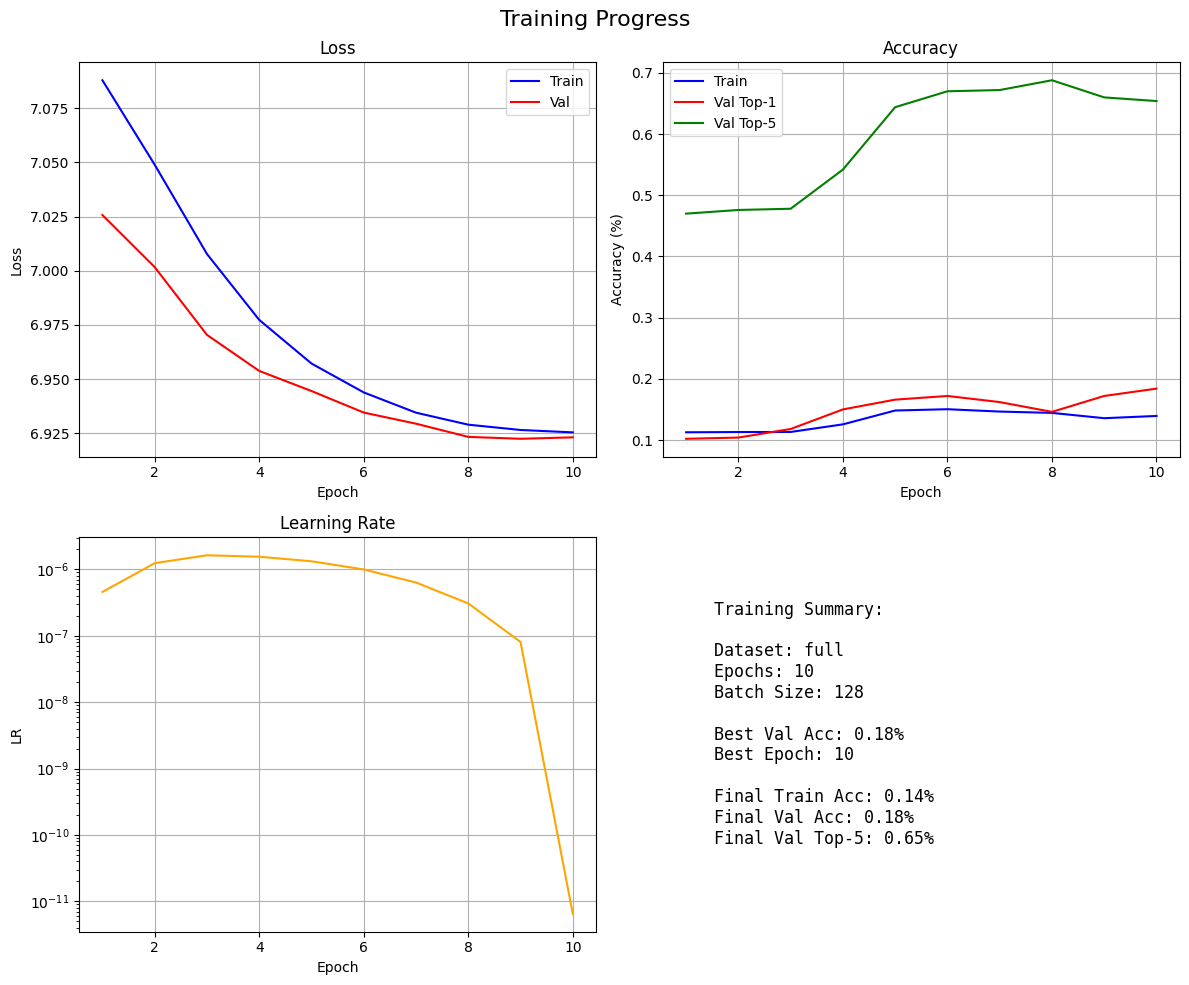

In [16]:
# Plot training curves
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

epochs = range(1, len(history['train_loss']) + 1)

# Loss plot
axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Train')
axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Val')
axes[0, 0].set_title('Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy plot
axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Train')
axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Val Top-1')
axes[0, 1].plot(epochs, history['val_acc_top5'], 'g-', label='Val Top-5')
axes[0, 1].set_title('Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Learning rate plot
axes[1, 0].plot(epochs, history['lr'], 'orange')
axes[1, 0].set_title('Learning Rate')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('LR')
axes[1, 0].set_yscale('log')
axes[1, 0].grid(True)

# Summary text
axes[1, 1].axis('off')
summary_text = f"""Training Summary:

Dataset: {config['dataset_type']}
Epochs: {config['epochs']}
Batch Size: {config['batch_size']}

Best Val Acc: {best_val_acc:.2f}%
Best Epoch: {best_epoch + 1}

Final Train Acc: {history['train_acc'][-1]:.2f}%
Final Val Acc: {history['val_acc'][-1]:.2f}%
Final Val Top-5: {history['val_acc_top5'][-1]:.2f}%
"""
axes[1, 1].text(0.1, 0.5, summary_text, fontsize=12, 
                verticalalignment='center', fontfamily='monospace')

plt.suptitle('Training Progress', fontsize=16)
plt.tight_layout()
plt.savefig(f"{config['plot_dir']}/training_curves.png", dpi=100)
plt.show()

## 11. Save Training History

In [17]:
# Save training history
history_path = f"{config['log_dir']}/training_history.json"
with open(history_path, 'w') as f:
    json.dump(history, f, indent=4)
print(f"Training history saved to {history_path}")

# Save configuration
config_path = f"{config['log_dir']}/config.json"
with open(config_path, 'w') as f:
    json.dump(config, f, indent=4)
print(f"Configuration saved to {config_path}")

Training history saved to ./logs/training_history.json
Configuration saved to ./logs/config.json


## 12. Test the Best Model

In [18]:
# Load best model
checkpoint = torch.load(f"{config['checkpoint_dir']}/best_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch'] + 1}")

# Final evaluation
model.eval()
val_loss, val_acc, val_acc_top5, _ = test_epoch(
    model, device, val_loader, criterion,
    epoch=checkpoint['epoch'], verbose=True, calc_top5=True
)

print(f"\nBest Model Performance:")
print(f"  Validation Loss: {val_loss:.4f}")
print(f"  Validation Top-1 Accuracy: {val_acc:.2f}%")
print(f"  Validation Top-5 Accuracy: {val_acc_top5:.2f}%")

/tmp/ipykernel_842873/221186952.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(f"{config['checkpoint_dir']}/best_model.pth")


Loaded best model from epoch 10


Epoch 9 [Test]: 100%|██████████| 391/391 [01:16<00:00,  5.09it/s, loss=6.9398, acc=0.18%, top5=0.65%]


Best Model Performance:
  Validation Loss: 6.9231
  Validation Top-1 Accuracy: 0.18%
  Validation Top-5 Accuracy: 0.65%


## 13. Inference Example

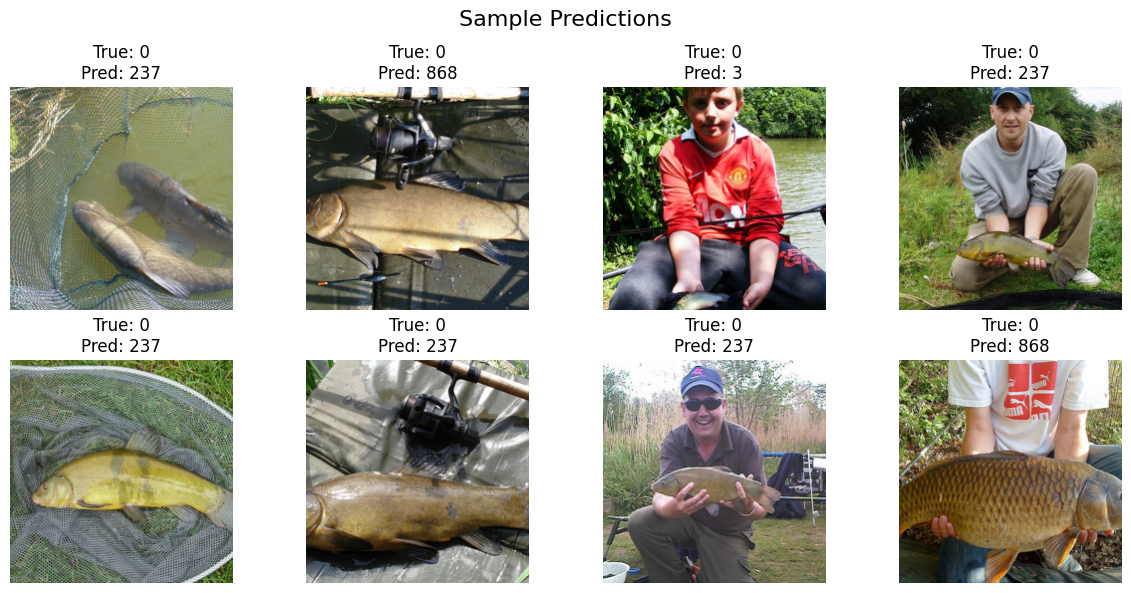

In [19]:
# Get a batch of validation images
model.eval()
images, labels = next(iter(val_loader))
images, labels = images[:8].to(device), labels[:8].to(device)

# Make predictions
with torch.no_grad():
    outputs = model(images)
    _, predicted = outputs.topk(5, 1, largest=True, sorted=True)

# Display results
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
axes = axes.ravel()

for i in range(8):
    # Denormalize image for display
    img = images[i].cpu()
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img * std + mean
    img = torch.clamp(img, 0, 1)
    
    # Display image
    axes[i].imshow(img.permute(1, 2, 0))
    axes[i].set_title(f'True: {labels[i].item()}\nPred: {predicted[i, 0].item()}')
    axes[i].axis('off')

plt.suptitle('Sample Predictions', fontsize=16)
plt.tight_layout()
plt.show()